In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import warnings , os
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import umap
import umap.plot

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

print("Setup Complete")

Setup Complete


original CODE: https://www.kaggle.com/code/ohseokkim/gan-how-does-gan-work

In [2]:
img_rows = 28
img_cols = 28
channels = 1 # Black and white

In [3]:
img_shape = (img_rows, img_cols, channels)

# size of noise vector to be used as generator input
z_dim = 100

# Modeling Generator and Discriminator

![](https://cdn-images-1.medium.com/max/880/1*EBbefSaB1VlrOqzAOSycWQ.gif)

Picture Credit: https://cdn-images-1.medium.com

## Modeling Generator

![](https://pytorch.org/tutorials/_images/dcgan_generator.png)

Picture credit: https://pytorch.org

In [4]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))
    
    return model

## Modeling Discriminator

![](https://miro.medium.com/max/1600/1*UipjlvULzSCCr1szzZpKYQ.jpeg)
picture credit: https://miro.medium.com

In [5]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(
            Conv2D(32,
                  kernel_size=3,
                  strides=2,
                  input_shape=img_shape,
                  padding='same'))
    
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(
            Conv2D(64,
                  kernel_size=3,
                  strides=2,
                  padding='same'))
    
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(
            Conv2D(128,
                  kernel_size=3,
                  strides=2,
                  padding='same'))
    
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

## Modeling GAN

In [6]:
def build_gan(generator, discriminator):
    model = Sequential()
    
    # generator -> discriminator
    model.add(generator)
    model.add(discriminator)
    
    return model

## Creating discriminator

In [7]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                     optimizer=Adam(),
                     metrics=['accuracy'])

# Preserve the parameters of the discriminator while training the generator
discriminator.trainable = False

## Creating generator

In [8]:
generator = build_generator(z_dim)

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## Defining training function

In [9]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    # Load MNIST
    (x_train, y_train), (_, _) = mnist.load_data()
    
    # [0, 255] scales black and white pixel values between [-1, 1]
    X_train = x_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    
    # real image label : all 1
    real = np.ones((batch_size, 1))
    
    # fake image label : all 0
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        ''' 
        Discriminant training
        '''
        
        # get random batches from real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        # create fake image batches
        z = np.random.normal(0, 1, (batch_size, 100)) # batch_size x 100 matrix 
        gen_imgs = generator.predict(z)
        
        # training 
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        '''
        Training generator
        '''
        
        z = np.random.normal(0, 1, (batch_size, 100)) # batch_size x 100 matrix 
        
        if iteration == 0:
            print("\nRandom noise input image")
            sample_images(x_train[idx], y_train[idx], generator)
            
        g_loss = gan.train_on_batch(z, real)
        
        if iteration < 200 and (iteration + 1) % 20 == 0:
            # save loss and accuracy to plot graphs after training 
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            
            print("%d [D Loss: %f, accuracy: %.2f%%] [G Loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            
            # generated image sample output
            sample_images(x_train[idx], y_train[idx], generator)
            
        elif (iteration + 1) % sample_interval == 0:
            # save loss and accuracy to plot graphs after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            
            print("%d [D Loss: %f, accuracy: %.2f%%] [G Loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            
            # generated image sample output      
            sample_images(x_train[idx], y_train[idx], generator)

In [10]:
(x_train, y_train), (_, _) = mnist.load_data()

In [11]:
print(x_train.shape)
print(y_train.shape)
print(_.shape)

(60000, 28, 28)
(60000,)
(10000,)


## Sampling and drawing images

In [12]:
image_grid_rows = 4
image_grid_columns = 4

In [13]:
def plot_dim_reduction(imgs, gen_imgs, img_labels):
    sns.set(style='ticks', context='talk', font_scale=1)
    plt.style.use('dark_background')
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'P', '*', 'X', '+', '*']
    plt.figure(figsize=(9,9))
    
    reshape_real_imgs = imgs.reshape(imgs.shape[0], -1)
    reshape_gen_imgs = gen_imgs.reshape(gen_imgs.shape[0], -1) * 255
    concat_img = np.concatenate([reshape_real_imgs, reshape_gen_imgs])
    
    fake_label = np.empty((image_grid_rows * image_grid_columns)) # 4 * 4 nearly zero matrix
    fake_label[:] = 11
    concat_label = np.concatenate([img_labels, fake_label])
    mapper = umap.UMAP().fit_transform(concat_img) # dimensionality reduction 
    
    for i, marker in enumerate(markers):
        mask = concat_label == i
        if i == 11:
            plt.scatter(mapper[mask, 0], mapper[mask, 1], label=i, s=100, alpha=1, marker=marker, c='yellow')
            
        else:
            plt.scatter(mapper[mask, 0], mapper[mask, 1], label=i, s=10, alpha=1, marker=marker)
    
    plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left', fontsize=15)
    plt.title("Plotting real and generated images after dimension reduction", fontsize=15) 

In [14]:
def plot_dist(gen_imgs):
    sns.set(style='ticks', context='talk', font_scale=1)
    plt.style.use('dark_background')
    plt.figure(figsize=(10, 6))
    sns.distplot(gen_imgs, color='purple', kde=True)
    plt.title("Generated Images Distribution", fontsize=20)
    plt.show()

In [15]:
def sample_images(imgs, img_labels, generator):
    # random noise sampling
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    
    # generate Image from random noise
    gen_imgs = generator.predict(z)
    
    # scale image pixel values between [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    plot_dim_reduction(imgs, gen_imgs, img_labels)
    plot_dist(gen_imgs)
    
    fig, axs = plt.subplots(image_grid_rows,
                           image_grid_columns,
                           figsize=(11,11),
                           sharey=True,
                           sharex=True)
    
    cnt = 0
    
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='Greys_r')
            axs[i, j].axis('off')
            cnt += 1
    
    plt.show()  

## Setting Hyperparameters

In [16]:
iterations = 3201
batch_size = 128
sample_interval = 400


Random noise input image


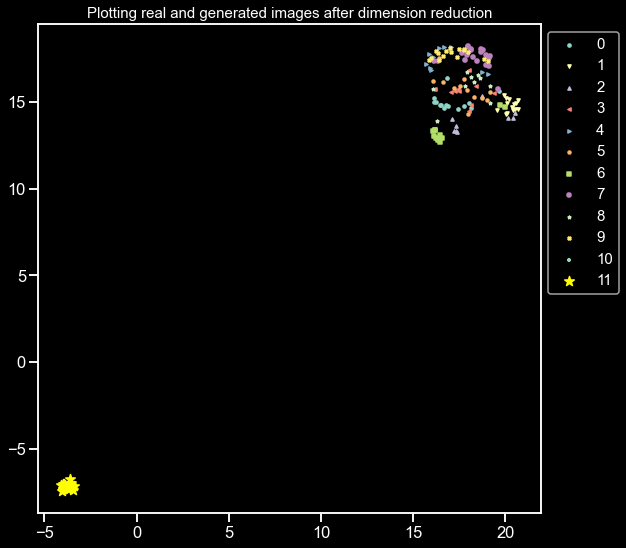

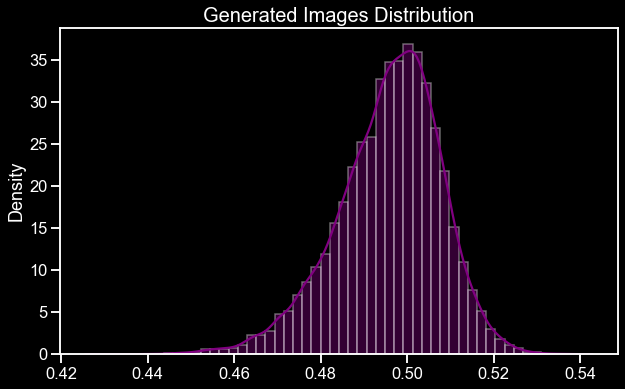

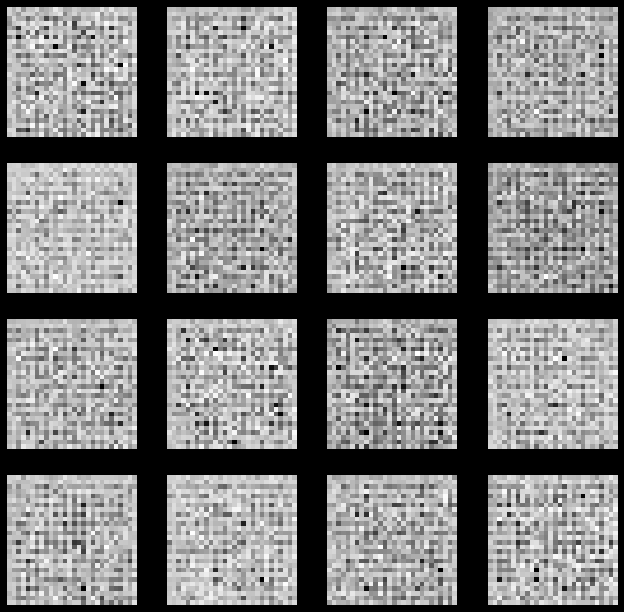

20 [D Loss: 0.070434, accuracy: 100.00%] [G Loss: 1.153177]


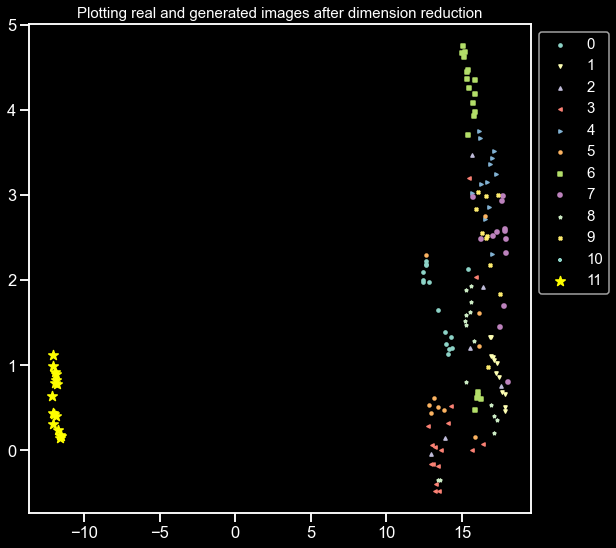

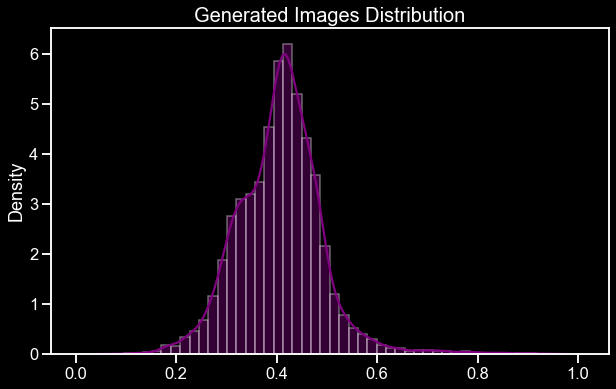

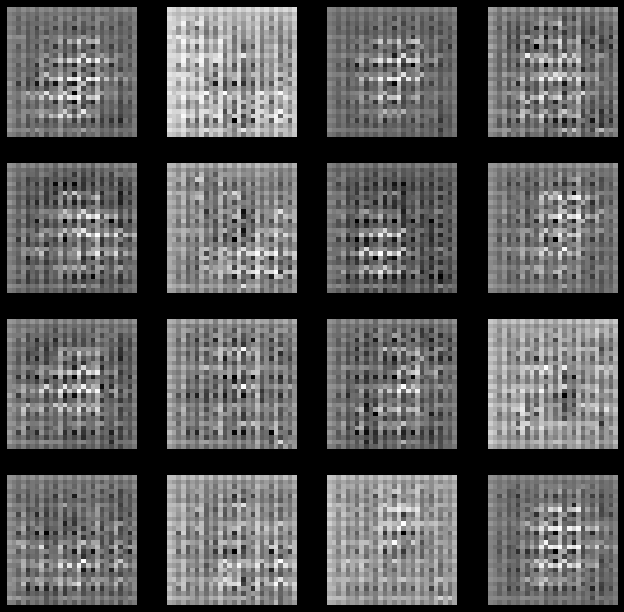

40 [D Loss: 0.000993, accuracy: 100.00%] [G Loss: 0.001519]


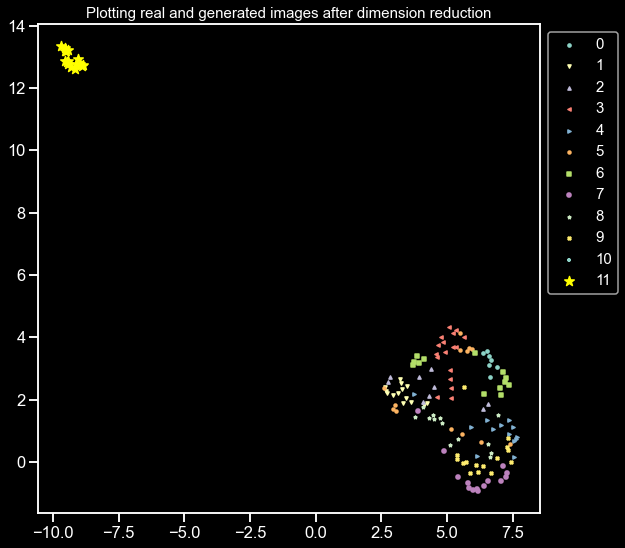

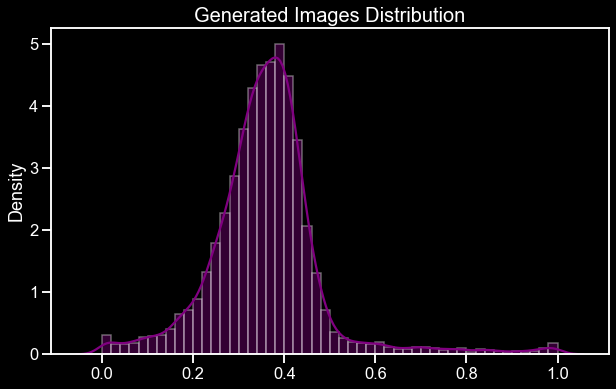

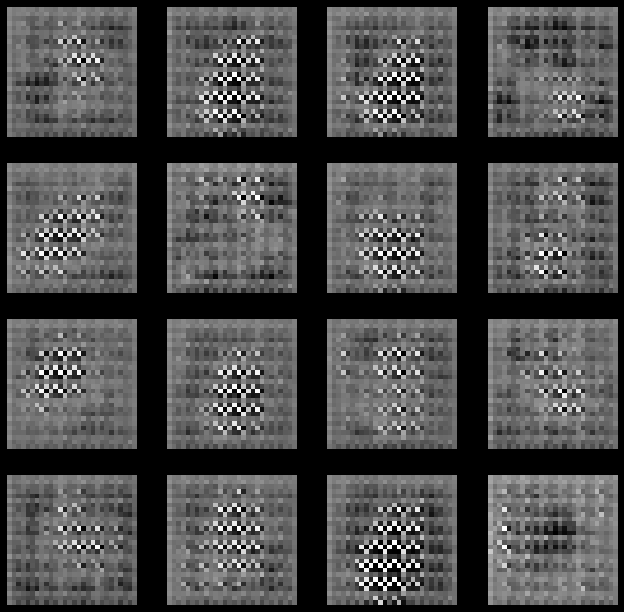

60 [D Loss: 0.000540, accuracy: 100.00%] [G Loss: 0.008978]


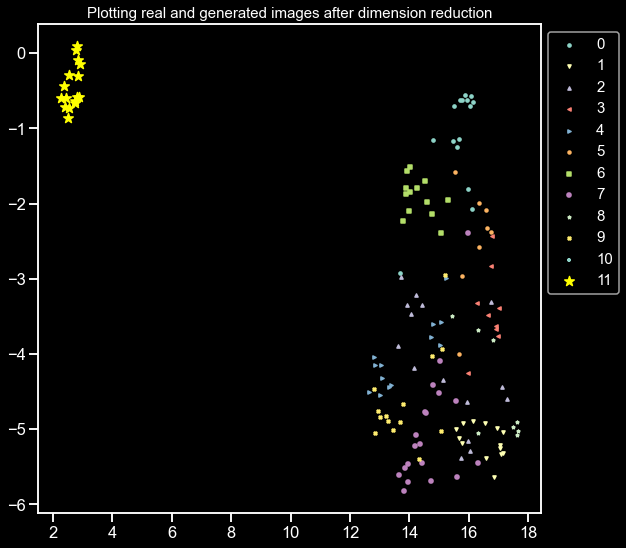

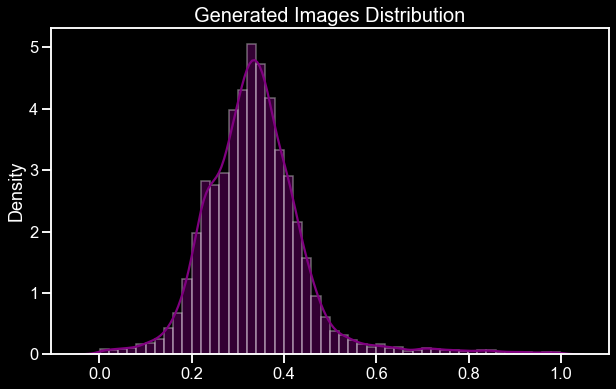

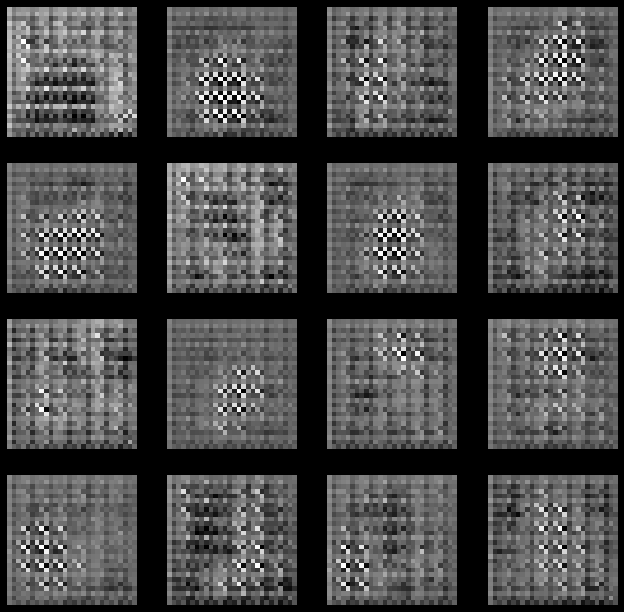

80 [D Loss: 0.000457, accuracy: 100.00%] [G Loss: 0.001978]


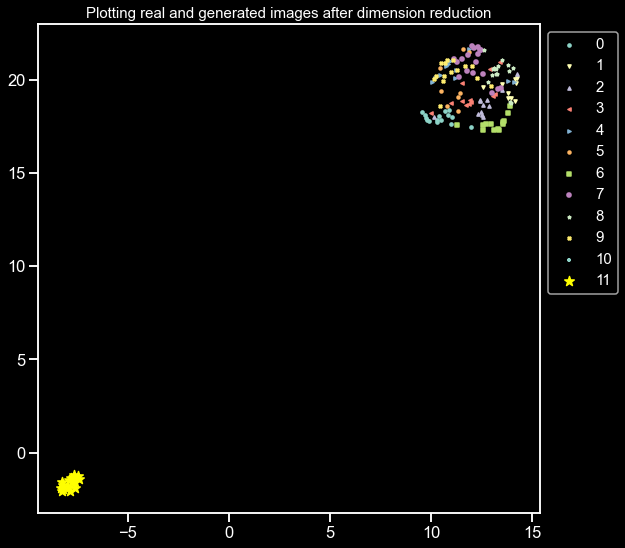

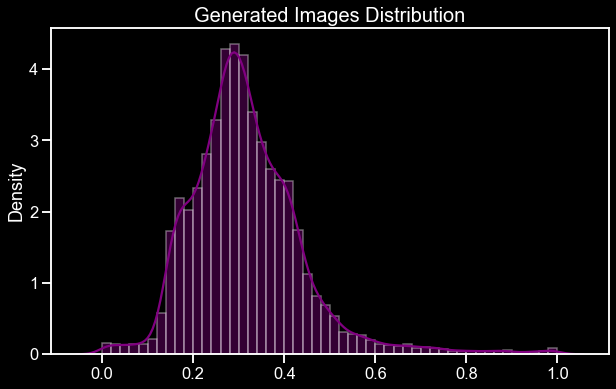

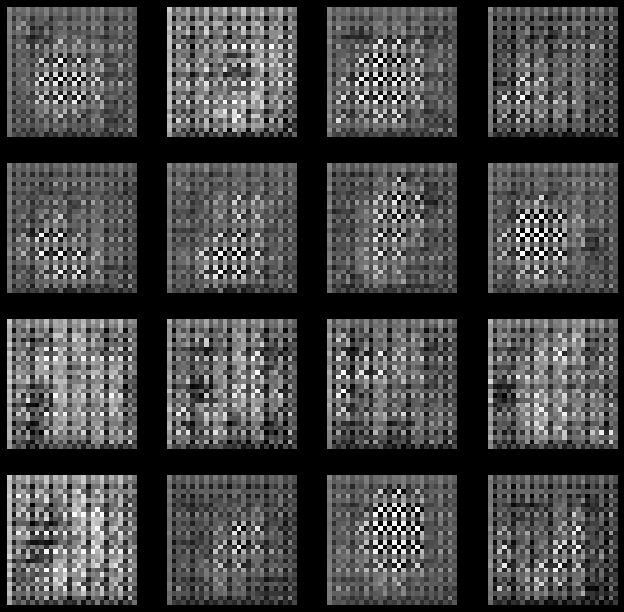

100 [D Loss: 0.000081, accuracy: 100.00%] [G Loss: 0.001241]


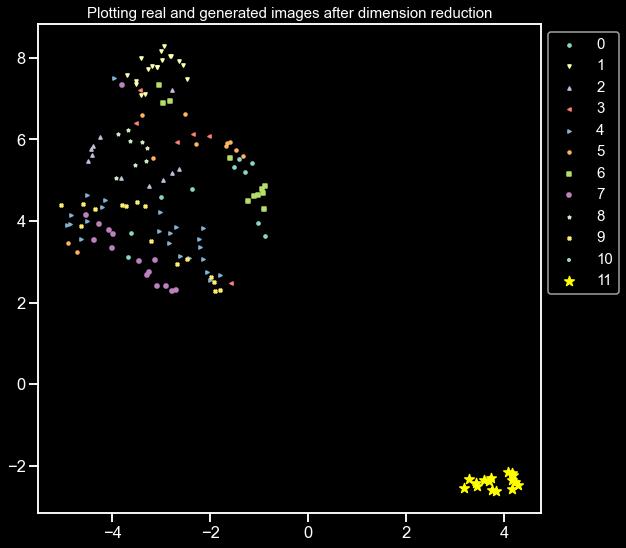

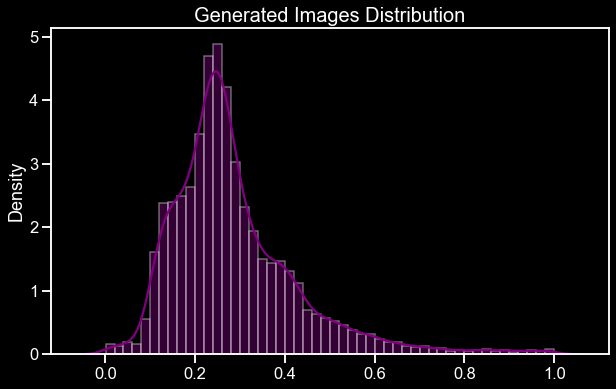

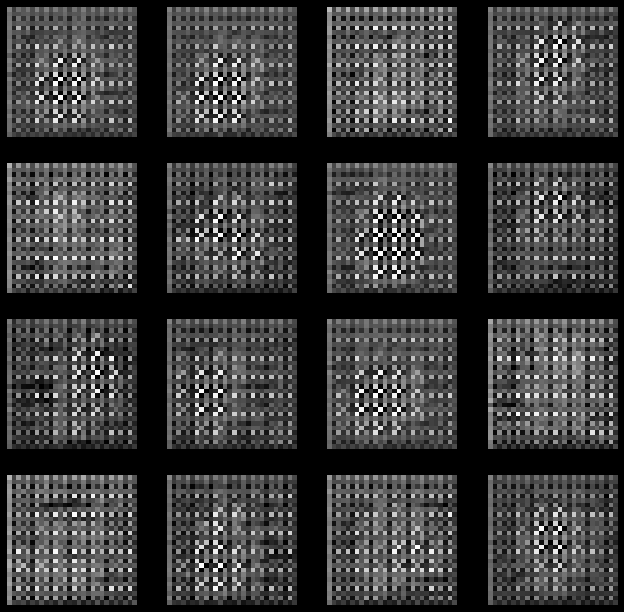

120 [D Loss: 0.000069, accuracy: 100.00%] [G Loss: 0.001905]


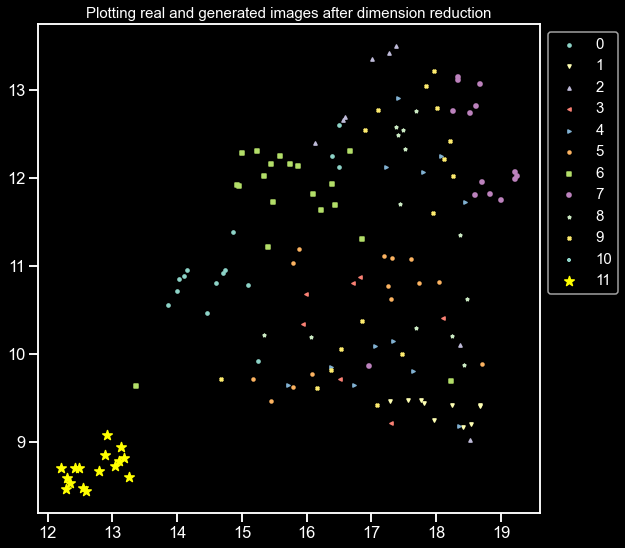

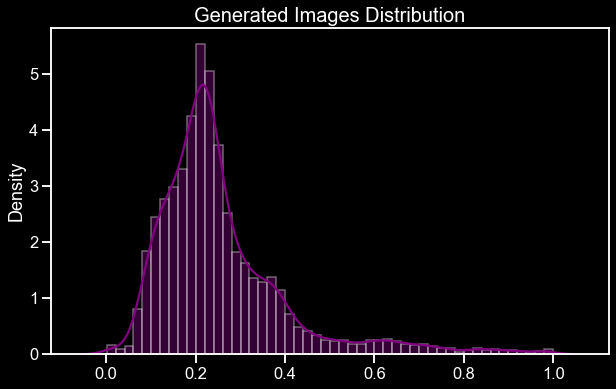

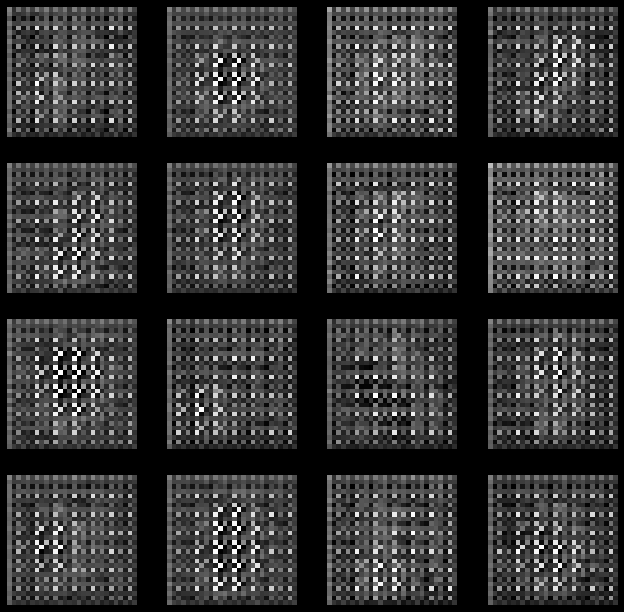

140 [D Loss: 0.004118, accuracy: 100.00%] [G Loss: 4.815879]


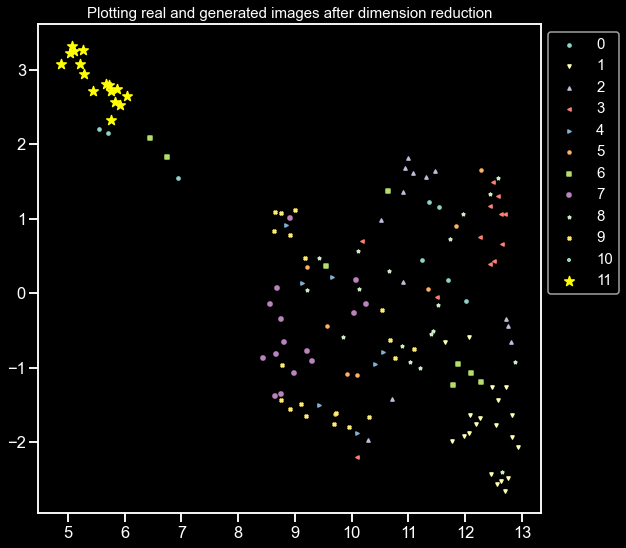

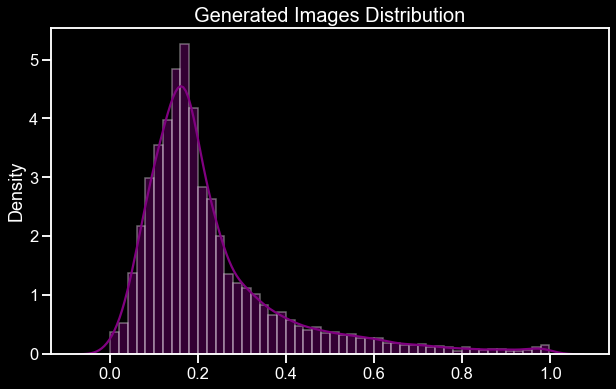

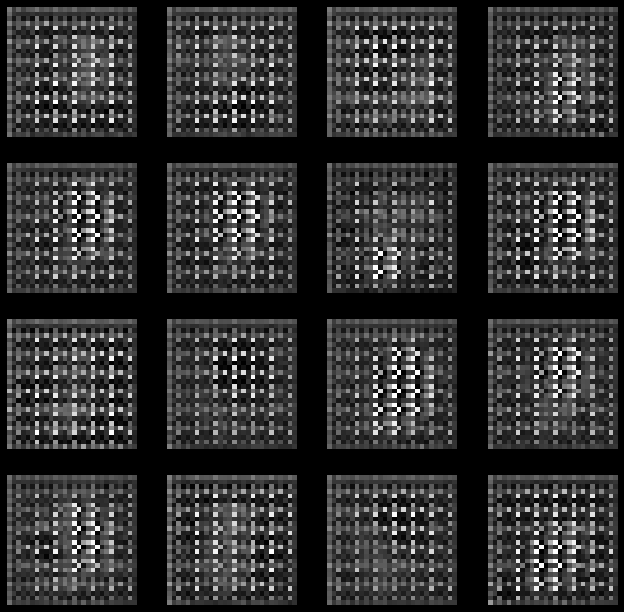

160 [D Loss: 0.232693, accuracy: 89.45%] [G Loss: 0.019390]


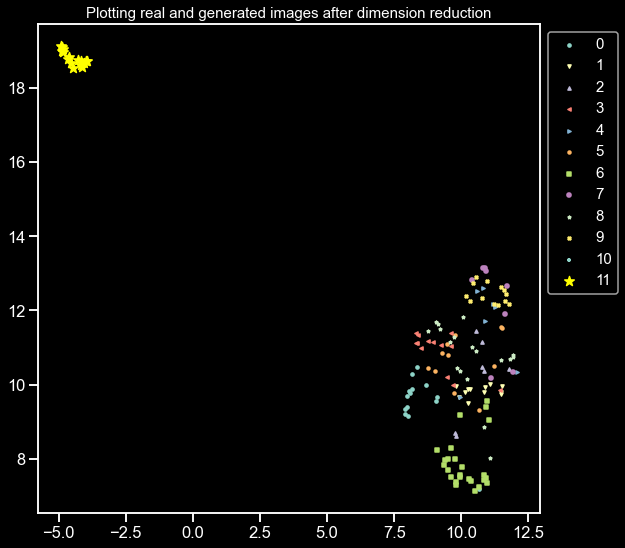

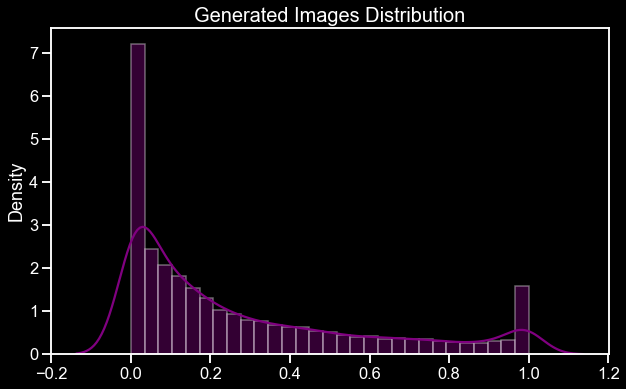

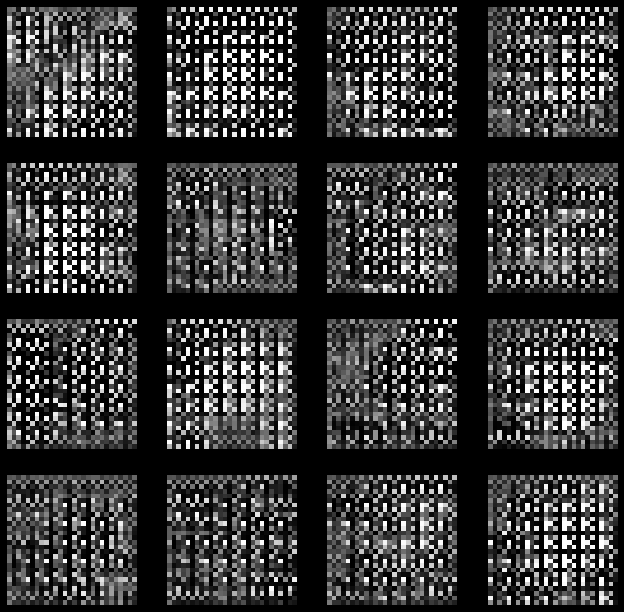

180 [D Loss: 0.042636, accuracy: 99.61%] [G Loss: 0.349806]


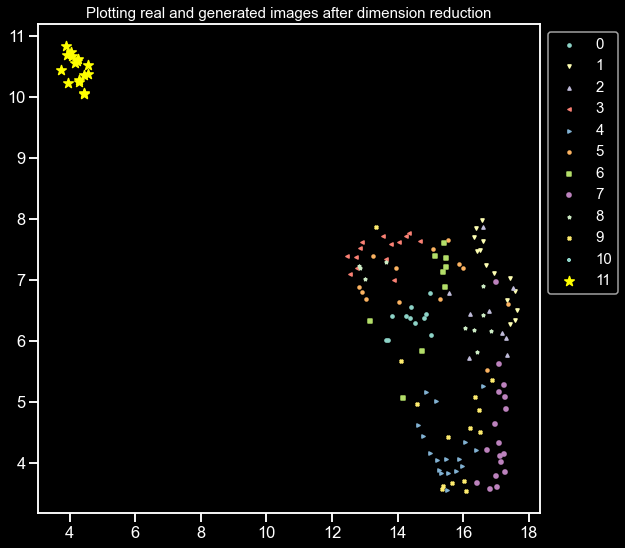

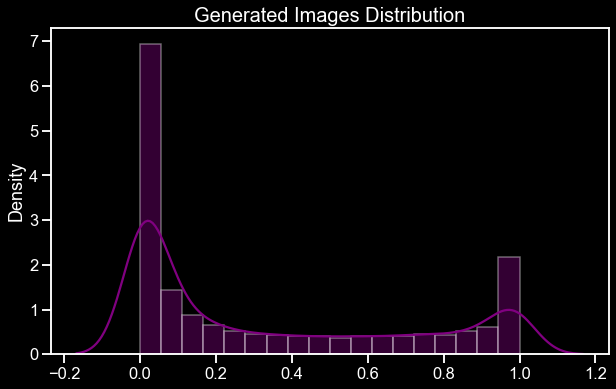

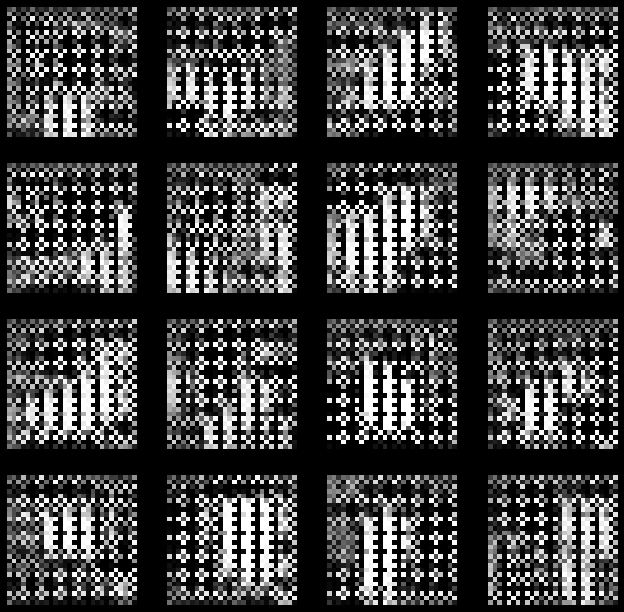

200 [D Loss: 0.002426, accuracy: 100.00%] [G Loss: 0.441835]


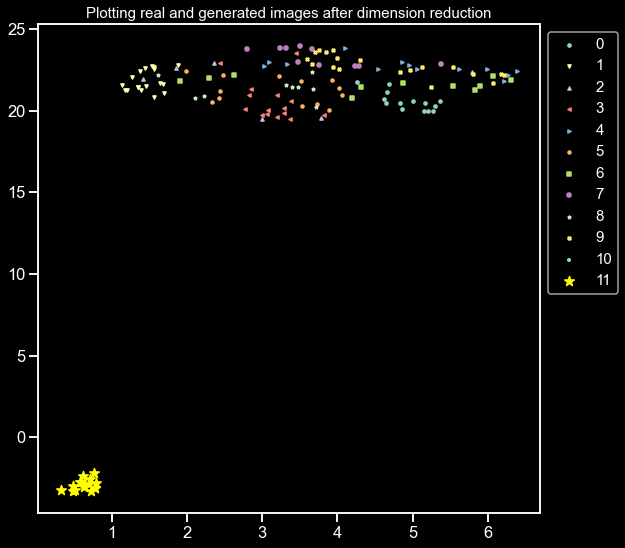

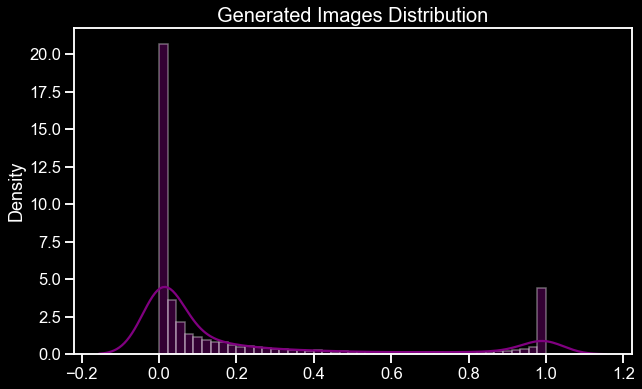

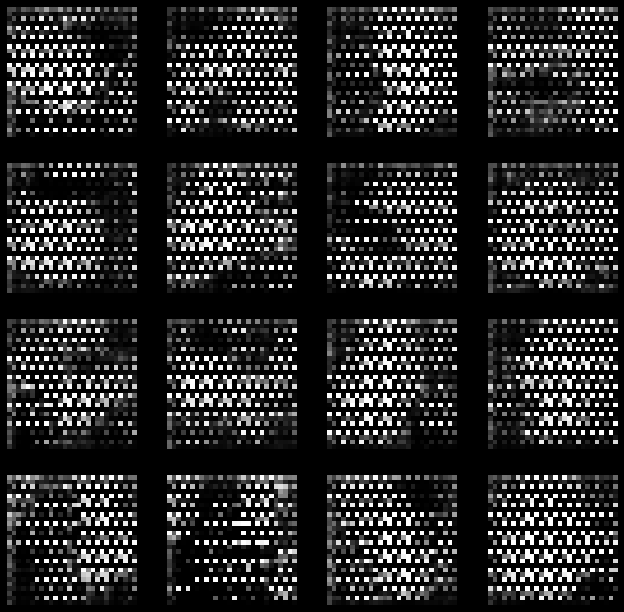

400 [D Loss: 0.363638, accuracy: 84.77%] [G Loss: 3.714571]


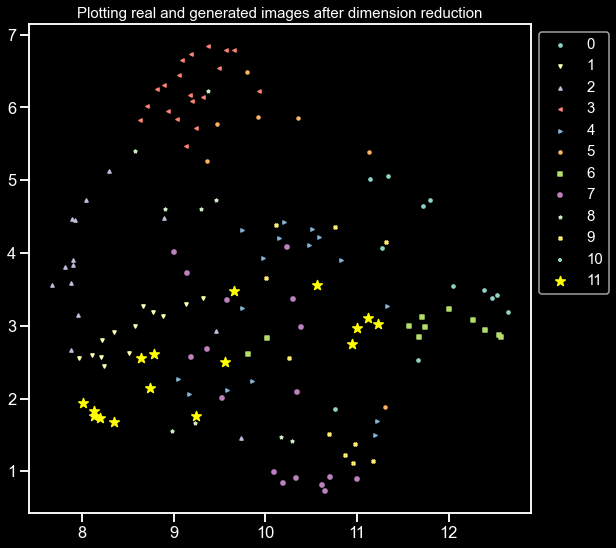

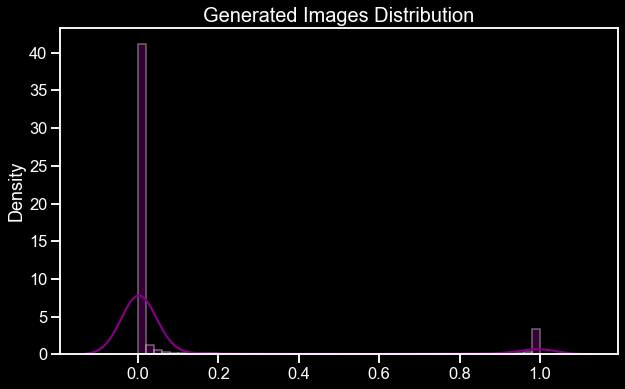

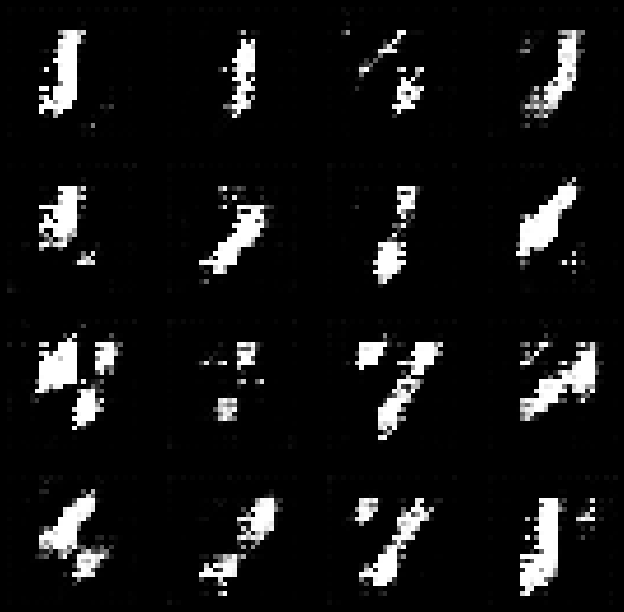

800 [D Loss: 0.374416, accuracy: 86.72%] [G Loss: 2.024012]


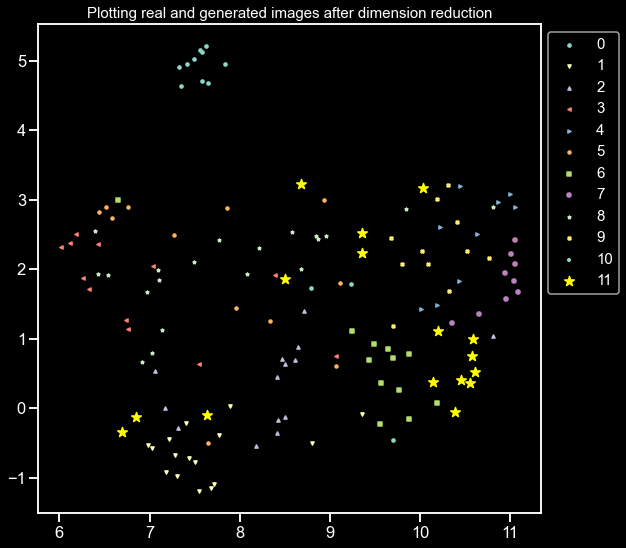

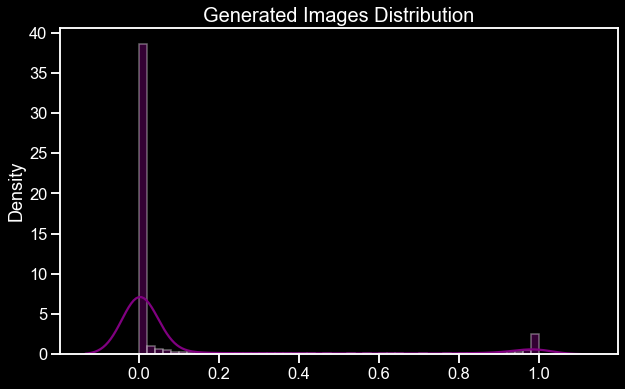

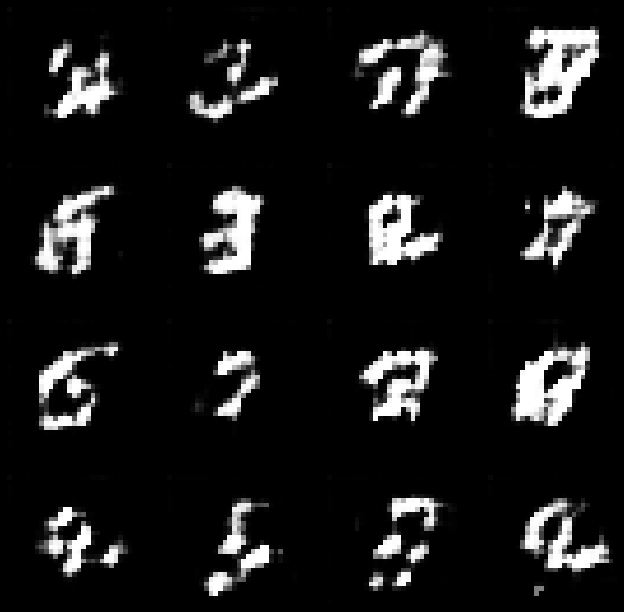

1200 [D Loss: 0.343288, accuracy: 86.72%] [G Loss: 2.659883]


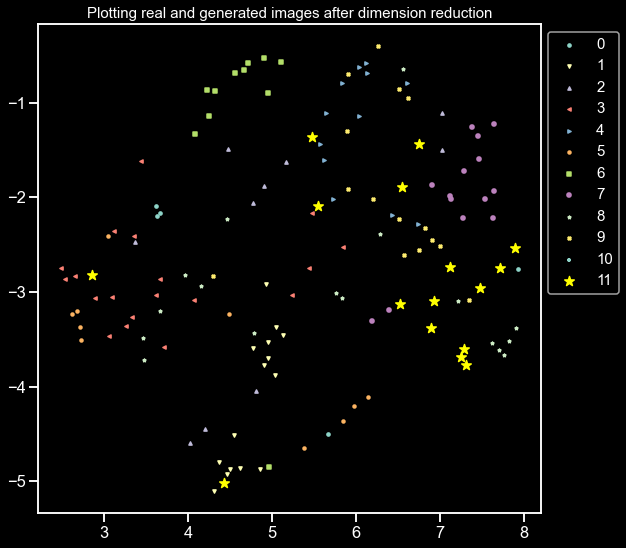

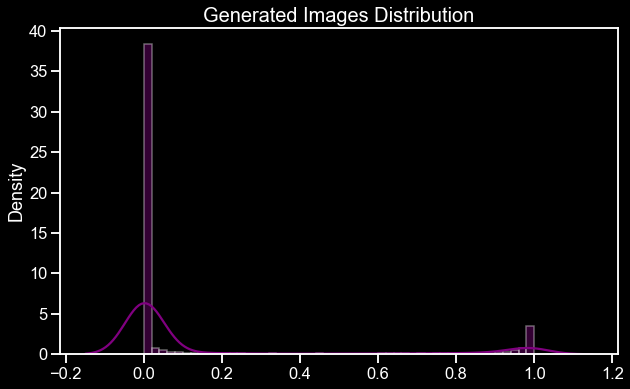

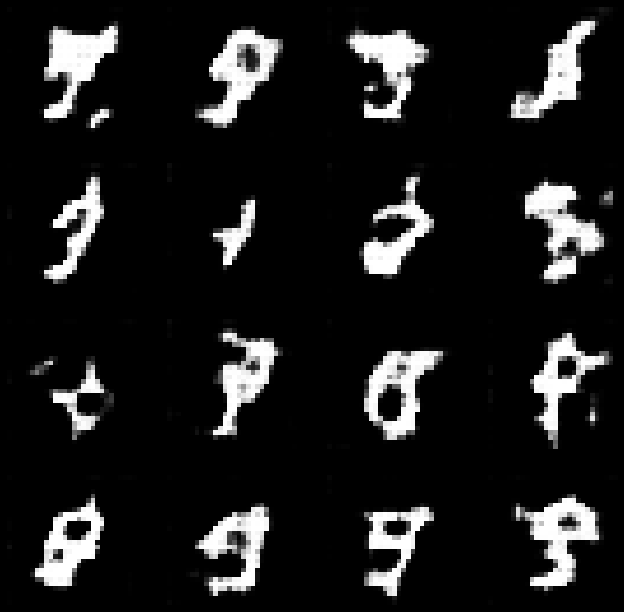

1600 [D Loss: 0.335761, accuracy: 84.77%] [G Loss: 1.957010]


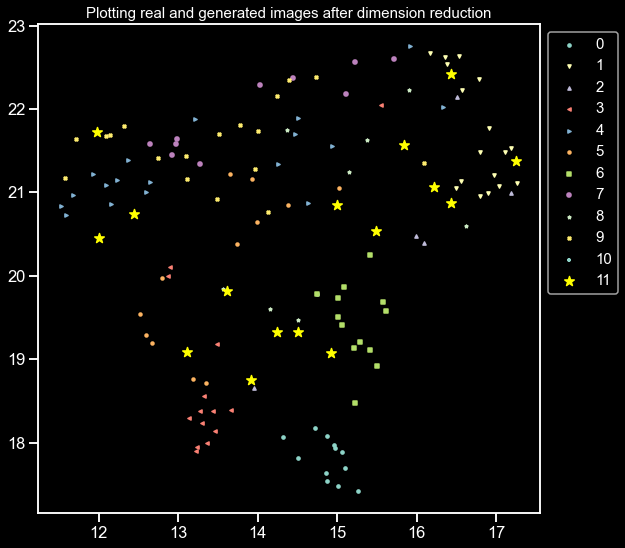

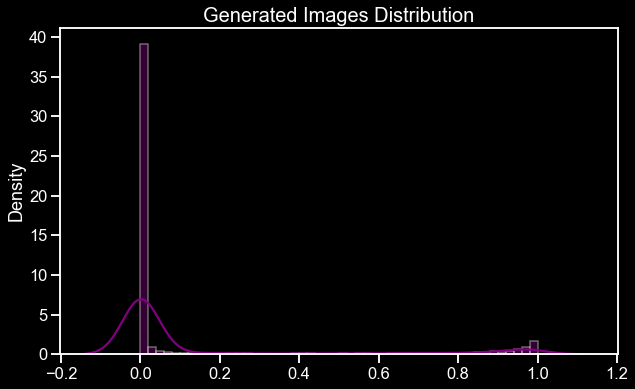

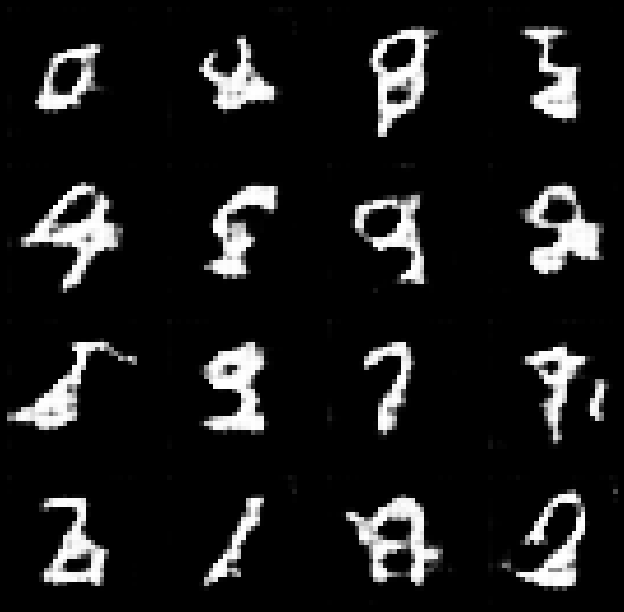

2000 [D Loss: 0.439949, accuracy: 79.30%] [G Loss: 1.714034]


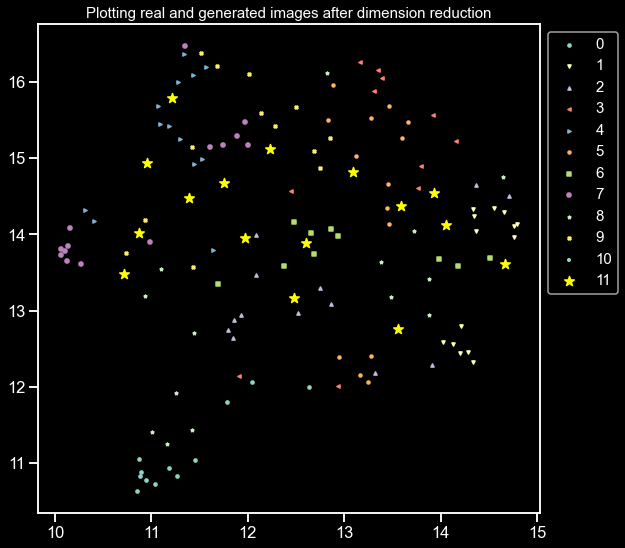

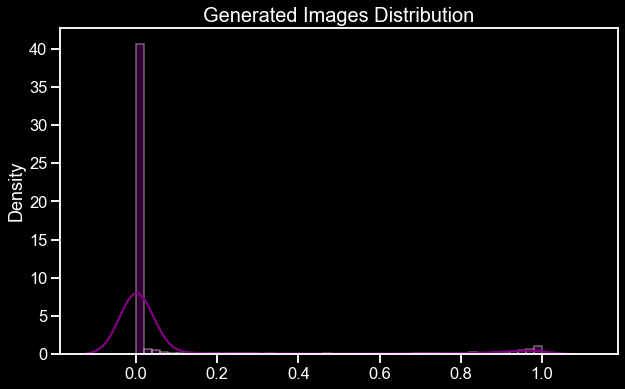

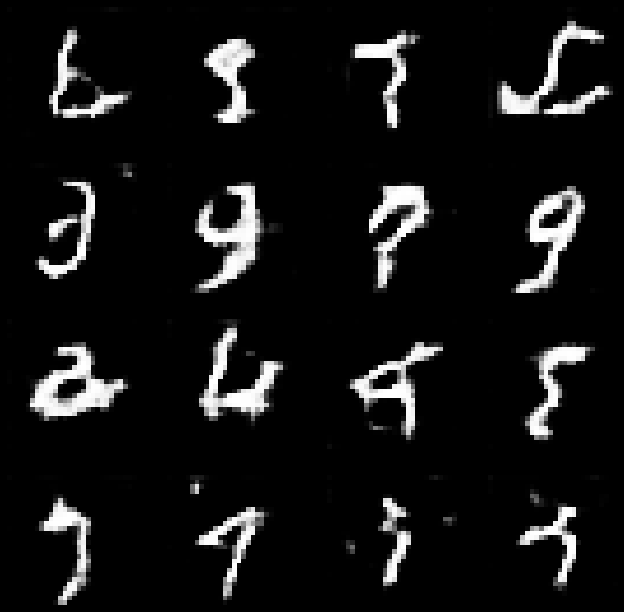

2400 [D Loss: 0.337520, accuracy: 86.33%] [G Loss: 2.280607]


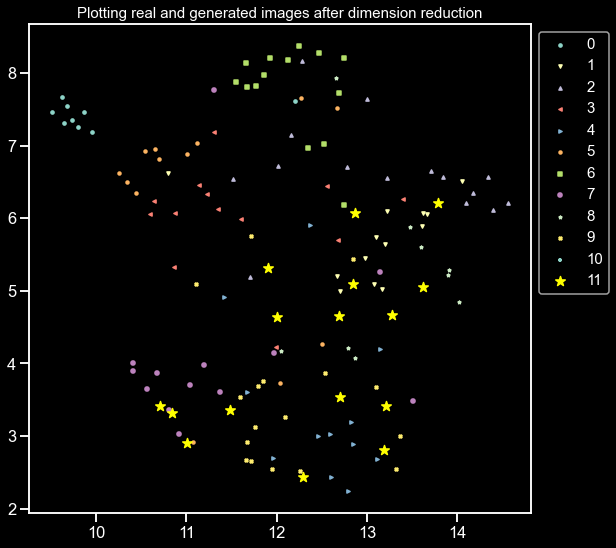

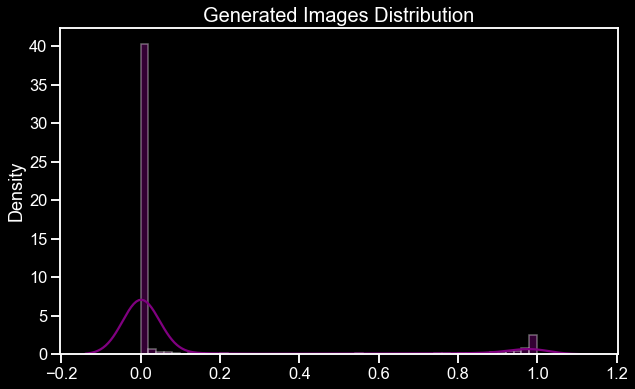

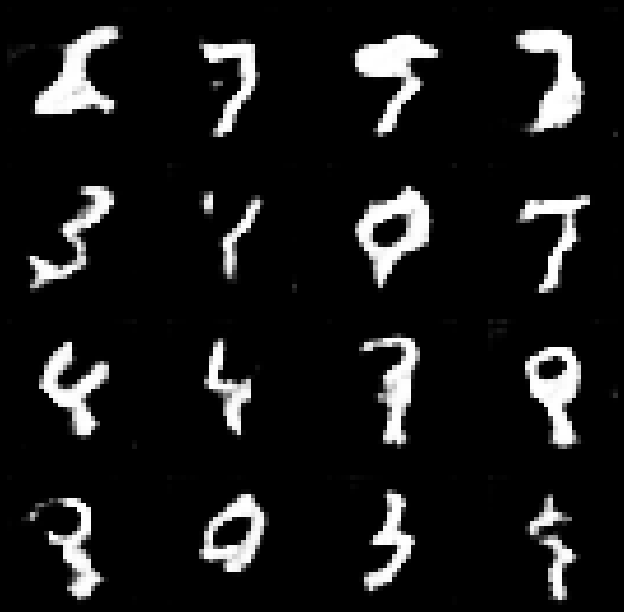

2800 [D Loss: 0.408847, accuracy: 82.03%] [G Loss: 1.808889]


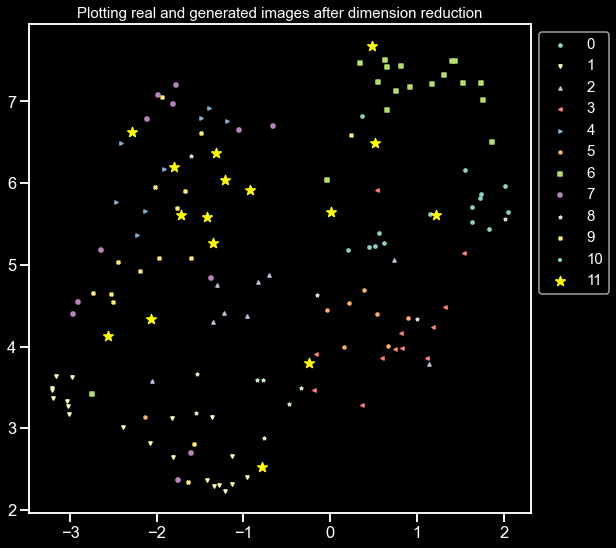

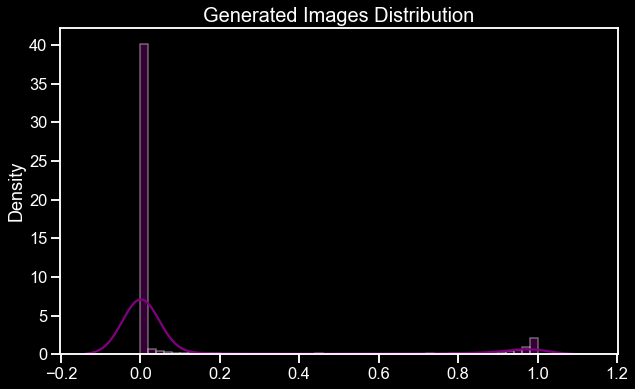

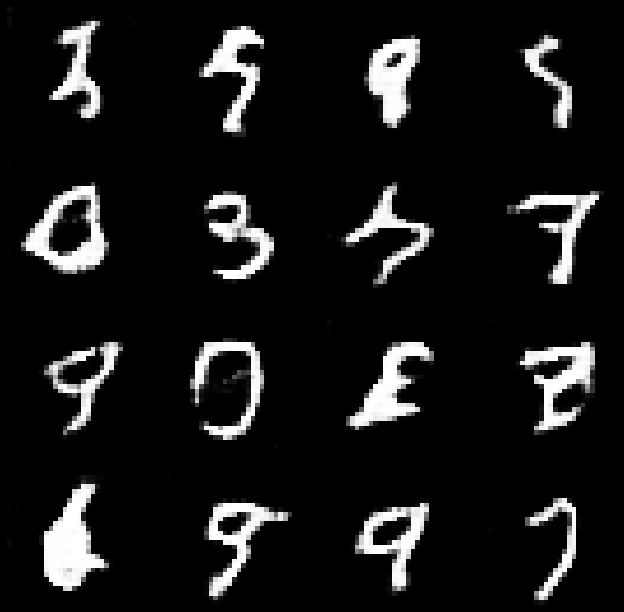

3200 [D Loss: 0.422465, accuracy: 82.42%] [G Loss: 1.786755]


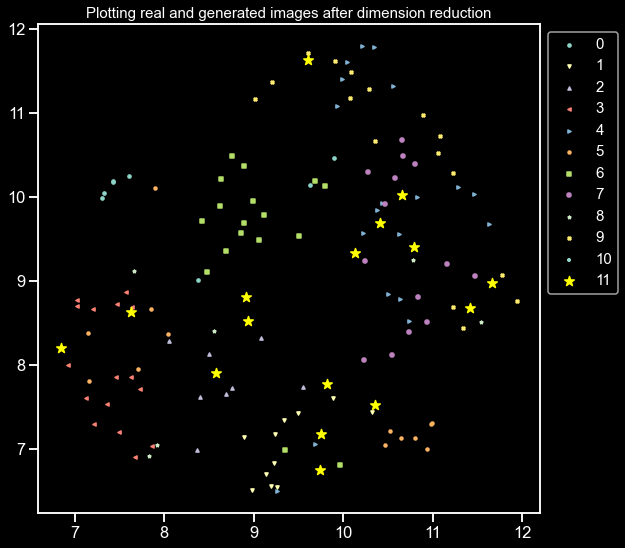

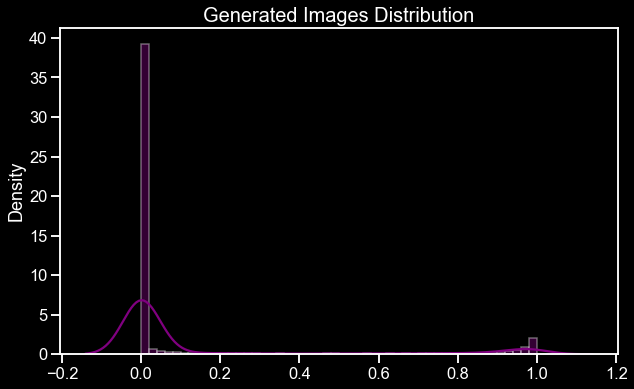

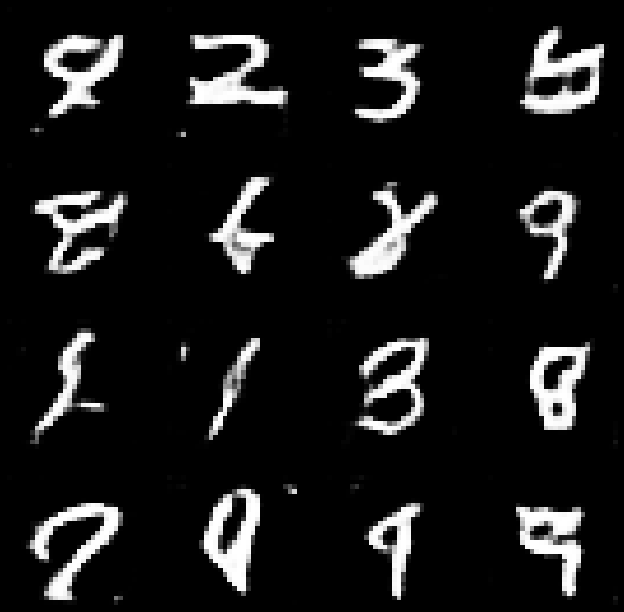

In [17]:
# DCGAN training for a specified number of ierations
train(iterations, batch_size, sample_interval)

## Checking Results

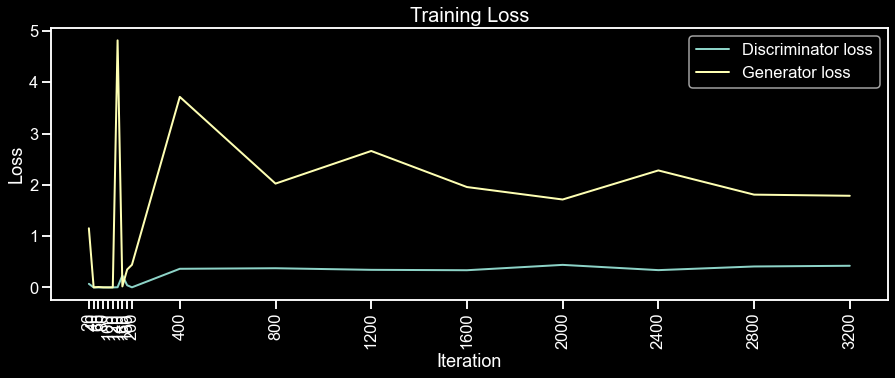

In [18]:
losses = np.array(losses)

# Training loss graph of discriminant and generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss",linewidth=2)
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss",linewidth=2)

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss",fontsize = 20)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

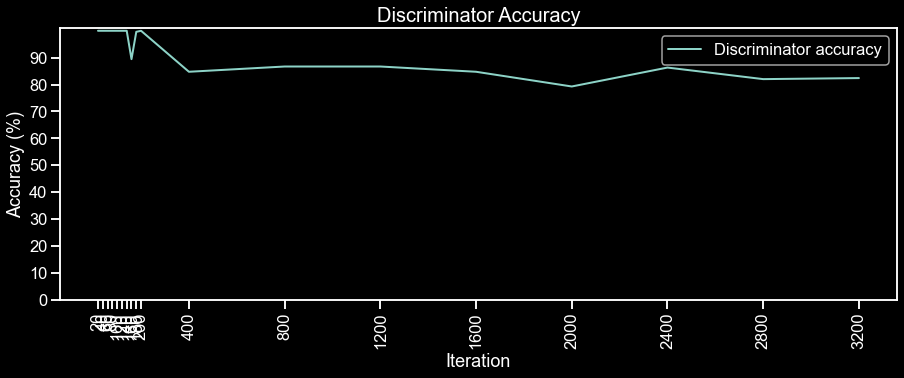

In [19]:
accuracies = np.array(accuracies)

# Discriminator Accuracy Graph
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy",linewidth=2)

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 10))

plt.title("Discriminator Accuracy",fontsize = 20)
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

### Conclusion
More training is needed to get better results. However, the purpose of this notebook is to understand how DCGAN creates plausible generated images from random noise images. In addition, since training of GAN requires a lot of time, we will be satisfied with the results obtained now.